In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model

In [2]:
trans_new=pd.read_csv('trans_new.csv')

In [3]:
## let's set index to be a WEEK_END_DATE variable
trans_new.set_index('WEEK_END_DATE',inplace=True)

### As the first step of modeling let's build a simple model that considers the only one product with UPC 1111009477. For this product let's try to predict the units sold by using linear regression models with regularization (Ridge & LASSO and elastic net) 

In [142]:
# data=trans_new[((trans_new.STORE_ID==367) & (trans_new.UPC==1111009477))]
## let's drop columns that have only a single value and therefore have no predictive power. 
data=trans_new[ (trans_new.UPC==1111009477)]
data=data[data.columns[data.nunique()!=1] ]


In [144]:
## let's sort dataframe by time in order to get proper CV scores
data=data.sort_values(by='WEEK_END_DATE')

In [145]:
data.nunique()

STORE_ID                     77
UNITS                       267
VISITS                      216
HHS                         215
SPEND                      3368
PRICE                        80
BASE_PRICE                   75
FEATURE                       2
DISPLAY                       2
TPR_ONLY                      2
STORE_NAME                   73
ADDRESS_CITY_NAME            51
ADDRESS_STATE_PROV_CODE       4
MSA_CODE                      9
SEG_VALUE_NAME                3
PARKING_SPACE_QTY            24
SALES_AREA_SIZE_NUM          73
AVG_WEEKLY_BASKETS           77
dtype: int64

In [146]:
data.columns

Index(['STORE_ID', 'UNITS', 'VISITS', 'HHS', 'SPEND', 'PRICE', 'BASE_PRICE',
       'FEATURE', 'DISPLAY', 'TPR_ONLY', 'STORE_NAME', 'ADDRESS_CITY_NAME',
       'ADDRESS_STATE_PROV_CODE', 'MSA_CODE', 'SEG_VALUE_NAME',
       'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS'],
      dtype='object')

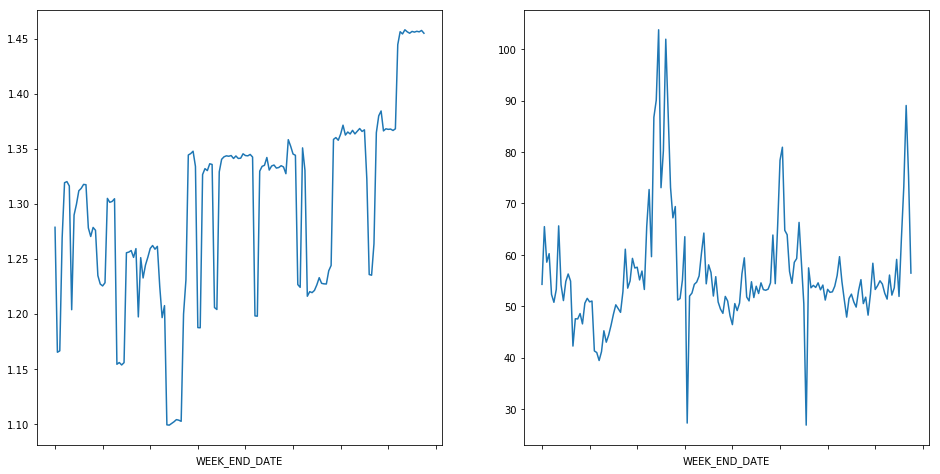

In [147]:
## In both graphs of historical price and units sold we can observe seasonality 
f,ax=plt.subplots(1,2,figsize=(16,8))
data.groupby('WEEK_END_DATE')['PRICE'].mean().plot(ax=ax[0])
data.groupby('WEEK_END_DATE')['UNITS'].mean().plot(ax=ax[1])

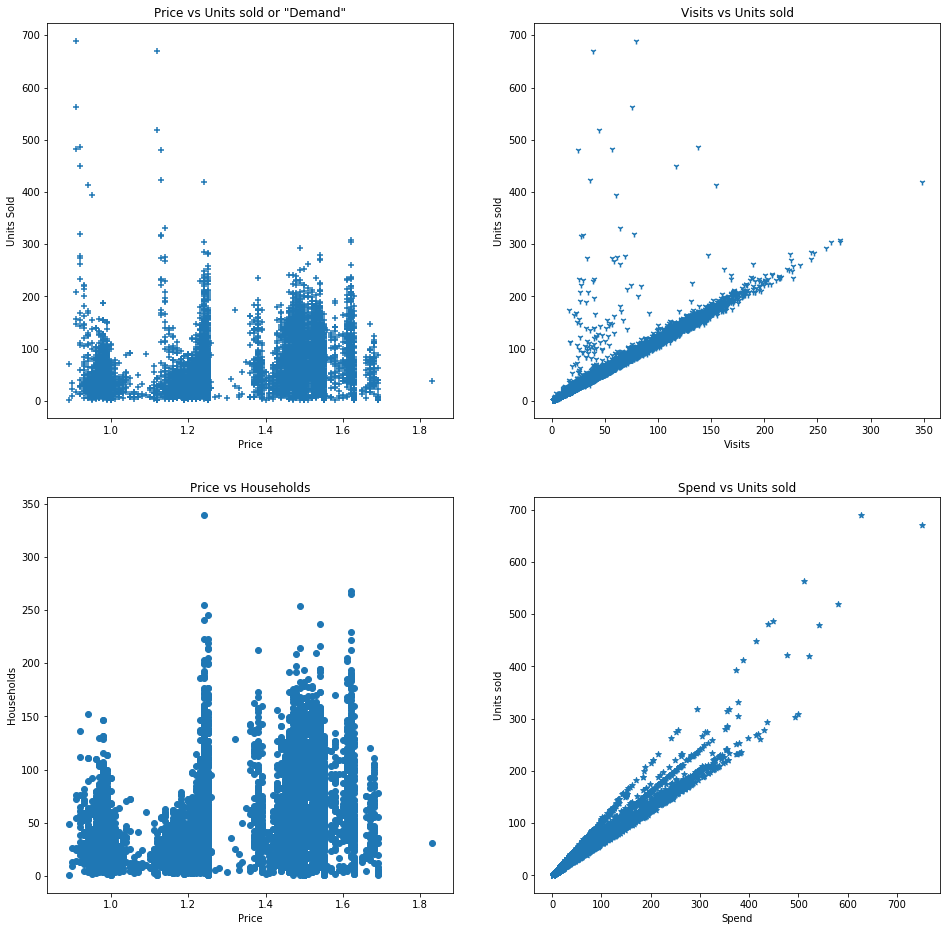

In [148]:
f, ax = plt.subplots(2,2,figsize=(16,16))
# plt.xlim(1,2)
ax[0,0].scatter(data.PRICE, data.UNITS, marker='+')
ax[0,0].set_xlabel('Price')
ax[0,0].set_ylabel('Units Sold')
ax[0,0].set_title('Price vs Units sold or "Demand"')

ax[0,1].scatter(data.VISITS, data.UNITS, marker='1')
ax[0,1].set_xlabel('Visits')
ax[0,1].set_ylabel('Units sold')
ax[0,1].set_title('Visits vs Units sold')

ax[1,0].scatter(data.PRICE, data.HHS, marker='o')
ax[1,0].set_xlabel('Price')
ax[1,0].set_ylabel('Households')
ax[1,0].set_title('Price vs Households')

ax[1,1].scatter(data.SPEND, data.UNITS, marker='*')
ax[1,1].set_xlabel('Spend')
ax[1,1].set_ylabel('Units sold')
ax[1,1].set_title('Spend vs Units sold')

plt.show()

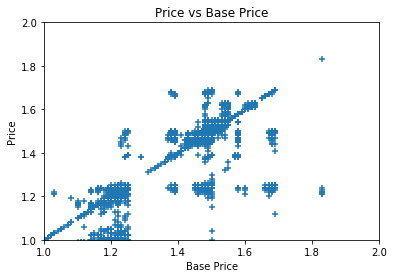

In [149]:
plt.title('Price vs Base Price')
plt.xlabel('Base Price')
plt.ylabel('Price')
plt.xlim(1,2)
plt.ylim(1,2)
plt.scatter(data.BASE_PRICE, data.PRICE ,marker='+')

In [150]:
data=pd.get_dummies(data,columns=['ADDRESS_STATE_PROV_CODE', 'MSA_CODE', 'SEG_VALUE_NAME' ])

In [166]:
data['Discount']=data.PRICE/data.BASE_PRICE

In [169]:
## let's fill missing values in PARKING_SPACE_QTY column with median of that column
medPSQ=data.PARKING_SPACE_QTY.median()
data.PARKING_SPACE_QTY.fillna(medPSQ,inplace=True)

In [177]:
data.columns

Index(['STORE_ID', 'UNITS', 'VISITS', 'HHS', 'SPEND', 'PRICE', 'BASE_PRICE',
       'FEATURE', 'DISPLAY', 'TPR_ONLY', 'STORE_NAME', 'ADDRESS_CITY_NAME',
       'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS',
       'ADDRESS_STATE_PROV_CODE_IN', 'ADDRESS_STATE_PROV_CODE_KY',
       'ADDRESS_STATE_PROV_CODE_OH', 'ADDRESS_STATE_PROV_CODE_TX',
       'MSA_CODE_13140', 'MSA_CODE_17140', 'MSA_CODE_17780', 'MSA_CODE_19100',
       'MSA_CODE_19380', 'MSA_CODE_26420', 'MSA_CODE_43300', 'MSA_CODE_44220',
       'MSA_CODE_47540', 'SEG_VALUE_NAME_MAINSTREAM', 'SEG_VALUE_NAME_UPSCALE',
       'SEG_VALUE_NAME_VALUE', 'Discount'],
      dtype='object')

In [183]:
y=data.PRICE
X=data.drop(columns=['STORE_ID','PRICE','BASE_PRICE','SPEND','ADDRESS_CITY_NAME','STORE_NAME'])

In [179]:
X.columns

Index(['UNITS', 'VISITS', 'HHS', 'FEATURE', 'DISPLAY', 'TPR_ONLY',
       'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS',
       'ADDRESS_STATE_PROV_CODE_IN', 'ADDRESS_STATE_PROV_CODE_KY',
       'ADDRESS_STATE_PROV_CODE_OH', 'ADDRESS_STATE_PROV_CODE_TX',
       'MSA_CODE_13140', 'MSA_CODE_17140', 'MSA_CODE_17780', 'MSA_CODE_19100',
       'MSA_CODE_19380', 'MSA_CODE_26420', 'MSA_CODE_43300', 'MSA_CODE_44220',
       'MSA_CODE_47540', 'SEG_VALUE_NAME_MAINSTREAM', 'SEG_VALUE_NAME_UPSCALE',
       'SEG_VALUE_NAME_VALUE', 'Discount'],
      dtype='object')

In [185]:
%%time
tscv = TimeSeriesSplit(n_splits=5)
print('Ridge scores')

for train_index, test_index in tscv.split(X):
    X_train=X.iloc[train_index,:] 
    X_test=X.iloc[test_index,:] 
    y_train=y[train_index]
    y_test=y[test_index]
    reg1 = linear_model.Ridge(alpha=[.5]).fit(X_train,y_train)
    print( reg1.score(X_test,y_test)) 
    print(reg1.coef_ )

print('----------------------------')
print('Lasso scores')
for train_index, test_index in tscv.split(X):
    X_train=X.iloc[train_index,:] 
    X_test=X.iloc[test_index,:] 
    y_train=y[train_index]
    y_test=y[test_index]
    reg2 = linear_model.Lasso(alpha=.8,max_iter=100000).fit(X_train,y_train)
    print( reg2.score(X_test,y_test)) 
    print(reg2.coef_ )

print('----------------------------')
print('Elastic Net scores')

for train_index, test_index in tscv.split(X):
    X_train=X.iloc[train_index,:] 
    X_test=X.iloc[test_index,:] 
    y_train=y[train_index]
    y_test=y[test_index]
    reg3 = linear_model.ElasticNet(l1_ratio=.5,max_iter=100000).fit(X_train,y_train)
    print( reg3.score(X_test,y_test)) 
    print(reg3.coef_ )


Ridge scores
0.745276917817038
[-9.46424935e-04  1.88407167e-03 -1.26217445e-03 -3.71248321e-02
 -3.91534920e-03 -3.75263020e-02  5.57882955e-06 -3.61337052e-08
  3.22526667e-07  9.73457073e-04  4.77186001e-02  9.47552368e-02
 -1.43447294e-01 -1.91291483e-01  8.60651521e-02  8.33989230e-03
  4.35119014e-02 -5.19184881e-03 -3.71102141e-02  3.31026096e-02
  3.20659782e-02  3.05080124e-02  2.50017696e-03  2.48900591e-03
 -4.98918287e-03  8.01258480e-01]
0.7153159721710017
[-1.03524713e-04  2.96874321e-03 -3.50937073e-03 -3.67666605e-02
  9.86586478e-03 -6.46283538e-04  3.91690549e-06 -1.86875381e-07
  8.20904444e-07 -1.44000541e-02  5.70173676e-02  1.20547244e-01
 -1.63164558e-01 -1.67330278e-01  7.08185983e-02 -5.92639262e-02
  7.60614452e-02  1.18593574e-02 -7.63637918e-02  6.37319928e-02
  3.70794739e-02  4.34071281e-02  1.88140311e-03  6.91102546e-03
 -8.79242858e-03  8.61795710e-01]
0.8248902728258155
[-1.31006457e-04  1.86434686e-03 -2.25462365e-03 -5.69381715e-02
 -3.87859327e-03 -

In [173]:
reg3.coef_

array([-0.00000000e+00, -6.43696400e-02,  7.53715040e-01, -1.09772056e+00,
       -3.24880078e-01,  1.34118721e-01,  0.00000000e+00,  1.85832176e-02,
       -1.44475020e-03,  1.39467774e-05, -9.29913082e-05, -0.00000000e+00,
       -0.00000000e+00, -1.57763582e+00,  1.94076300e+00,  0.00000000e+00,
       -1.31363504e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        1.47148888e-01,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00])

In [186]:
price1=reg1.predict(X)    

price2=reg2.predict(X)    

price3=reg3.predict(X)    

In [187]:
Profit1=price1*X.UNITS
print(Profit1.sum())

Profit2=price2*X.UNITS
print(Profit2.sum())

Profit3=price3*X.UNITS
print(Profit3.sum())


920816.4854756994
909850.8618839731
914445.7326401545


### It seems that the price obained by using Ridge model results in the highest lifetime profit among the three models. At the same time it produces the best linear model that approximates the price curve. Therefore, for predicting price for the next two weeks let's use price1, to be more specific, let's predict price as a avegare over last period   

In [208]:
price_df=pd.DataFrame(price1,index=data.index)
price_df.columns=['price']

<Figure size 720x576 with 0 Axes>

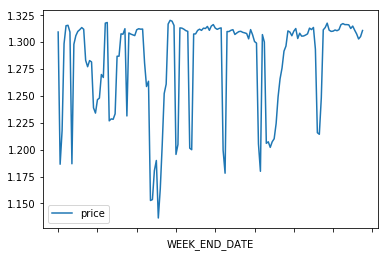

In [239]:
plt.figure(figsize=(10,8))
price_df=price_df.groupby('WEEK_END_DATE')['price'].mean().reset_index().set_index('WEEK_END_DATE')
price_df.plot()


In [243]:
print(' "Optimal" price for next two weeks for the product with UPC 1111009477 is:', price_df.tail().mean() )

 "Optimal" price for next two weeks for the product with UPC 1111009477 is: price    1.307538
dtype: float64
